# 19. MCMC (마르코프 체인 몬테 카를로)
- **3개 이상의 매개변수를 사용하는 경우 사용**
- '몬테 카를로' 분포에서 임의의 표본을 만드는 방법
* 그리드 방법과는 달리, MCMC에서는 사후분포를 구하지 않고, 표본을 가져옴

In [2]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

from utils import set_pyplot_params
set_pyplot_params()

<br>

## 19.01. 월드컵 문제

- 축구의 득점률을 $\lambda$로 나타낸 후, 포아송 프로세스로 축구에서의 득점을 모델링 
* $\lambda$의 사전분포를 나타내는 데 감마분포를 사용 
- 경기 결과를 데이터로 해서 각 팀의 사후분포를 계산

<br>



<br>

## 19.02. 그리드 근사

#### $\alpha=1.4$를 매개변수로 사용하는 감마사전분포


In [3]:
from scipy.stats import gamma

In [3]:
alpha = 1.4
prior_dist = gamma(alpha)

#### $\lambda$의 가능한 값을 만든 후, 사전분포의 이산 근사치 계산

In [4]:
import numpy as np
from utils import pmf_from_dist

In [5]:
lams = np.linspace(0, 10, 101)
prior_pmf = pmf_from_dist(prior_dist, lams)

#### 포아송분포를 사용하여, 데이터 가능도 계산
- 4개의 골을 넣은 경우

In [5]:
from scipy.stats import poisson

In [7]:
data = 4
likelihood = poisson.pmf(data, lams)

#### 갱신

In [8]:
posterior = prior_pmf * likelihood
posterior.normalize()

0.05015532557804499

<br>

## 19.03. 사전예측분포
- **사전예측분포를 구하는 한 가지 이유는 시스템에 대한 모델이 적절한지 확인을 위함**
- **MCMC의 첫 단계**

<br>

#### 사전분포에서 임의의 표본 추출
* 감마사전분포에서 1,000개 표본추출 : 득점률 $\lambda$의 가능한 값에 대한 배열

In [9]:
sample_prior = prior_dist.rvs(1000)

<br>

#### 감마사전분포에서 추출한 각각의 $\lambda$값을 평균으로 가지는 개별 포아송분포 생성
#### 개별 포아송분포에서 하나씩 값을 추출 $\rightarrow$  사전예측분포의 표본

In [10]:
sample_prior_pred = poisson.rvs(sample_prior)

<br>

#### 사전예측분포 표본의 PMF

In [6]:
from empiricaldist import Pmf

In [12]:
pmf_prior_pred = Pmf.from_seq(sample_prior_pred)

In [7]:
from utils import decorate

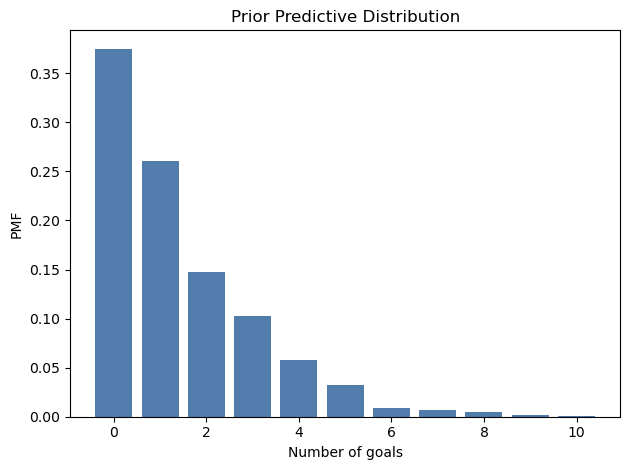

In [14]:
pmf_prior_pred.bar()
decorate(xlabel='Number of goals', ylabel='PMF', title='Prior Predictive Distribution')

<br>

## 19.04. `PyMC3`

- **`PyMC3`은 다양한 MCMC 방법을 제공하는 라이브러리**



<br>

<hr>

1. **주어진 매개변수에 대한 감마사전분포 생성**
2. **감마사전분포에 대한 포아송 사전예측분포 생성**


<br>

### `pymc3.Model()` : MCMC 객체 생성

In [9]:
import pymc3 as pm

In [16]:
with pm.Model() as model:
    lam = pm.Gamma('lam', alpha=1.4, beta=1.0)
    goals = pm.Poisson('goals', lam)

<br>

## 19.05. 사전예측분포 표본 추출


<br>

### `MCMC객체.sample_prior_predictive(n)` : 크기가 `n`의 사전예측분포의 표본 추출

In [21]:
with model:
    trace = pm.sample_prior_predictive(1000)

<br>

#### 각 매개변수별 표본
- **$\alpha=1.4,\;\beta=1.0$인 감마사전분포의 표본**

In [37]:
model.lam

lam ~ Gamma

In [38]:
trace['lam'].shape

(1000,)

- **감마사전분포를 따르는 $\lambda$를 매개변수로 가지는 포아송분포의 표본**

In [39]:
model.goals

goals ~ Poisson

In [40]:
trace['goals'].shape

(1000,)

<br>

### `scipy.stats`에서 생성한 감마사전분포 표본과, `PyMC3`으로 생성한 감마사전분포 표본의 CDF비교

In [47]:
sample_prior_pymc = trace['lam']
sample_prior_pymc.shape

(1000,)

In [10]:
from empiricaldist import Cdf

In [44]:
def plot_cdf(sample, **options):

    Cdf.from_seq(sample).plot(**options)

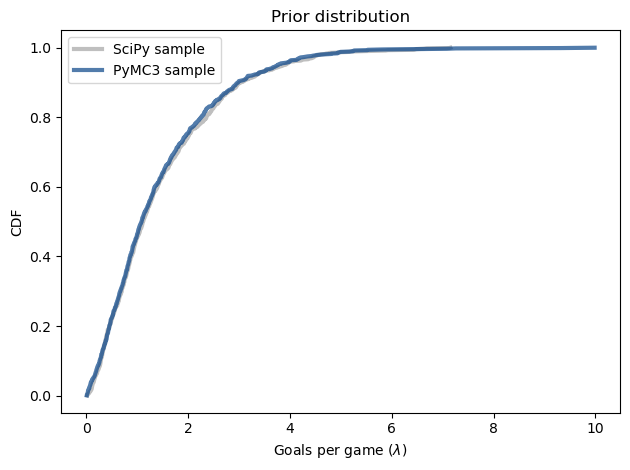

In [45]:
plot_cdf(sample_prior, label='SciPy sample', color='C5')
plot_cdf(sample_prior_pymc, label='PyMC3 sample', color='C0')

decorate(xlabel=r'Goals per game ($\lambda$)', ylabel='CDF', title='Prior distribution')

<br>

### `scipy.stats`와 `PyMC3`의 감마사전분포를 따르는 $\lambda$를 매개변수로 가지는, 각 포아송 사전예측분포 표본 CDF비교

In [51]:
sample_prior_pred_pymc = trace['goals']
sample_prior_pred_pymc.shape

(1000,)

In [53]:
def plot_pred(sample, **options):
    Cdf.from_seq(sample).step(**options)

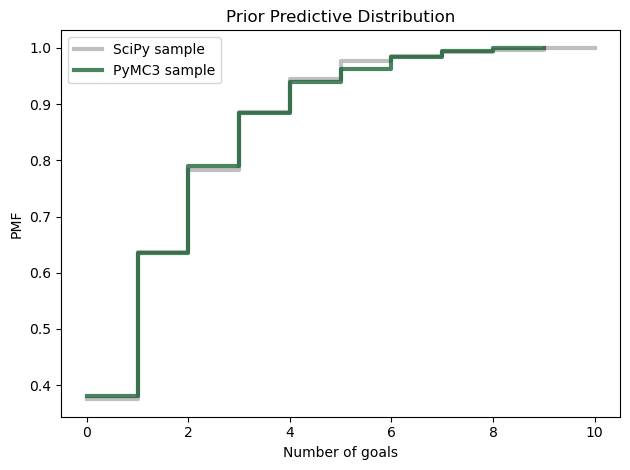

In [54]:
plot_pred(sample_prior_pred, label='SciPy sample', color='C5')
plot_pred(sample_prior_pred_pymc, label='PyMC3 sample', color='C13')

decorate(xlabel='Number of goals', ylabel='PMF', title='Prior Predictive Distribution')

<br>

## 19.06. 추론



#### 갱신 및 사후분포 계산
- **갱신하고자 하는 포아송분포의 관측값으로 `observed = 4`입력**

In [56]:
with pm.Model() as model2:
    lam = pm.Gamma('lam', alpha=1.4, beta=1.0)
    goals = pm.Poisson('goals', lam, observed=4)

In [60]:
model2.lam

lam ~ Gamma

In [61]:
model2.goals

goals ~ Poisson

<br>

### $\lambda$의 사후분포로부터 표본 추출
- 모델에 따라 `PyMC3`은 여러 MCMC기법과 표본추출법 사용 

    - ***[노 유턴 표본 추출기 (No U-Turn Sampler, NUTS)](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo#No_U-Turn_Sampler)* : 표본 500개를 지정했지만, `PyMC3`에서는 1,000개의 표본에 대한 두 개의 값을 생성 후, 각각의 값에서 반을 버리고, 남은 1,000개를 반환**
    
    <br>
    
- **표본추출이 시작되면, 처음 생성되는 값은 보통 사후분포를 대표하는 값이 아니므로, 튜닝이 진행**
- **`PyMC3`에서는 단일 마르코프 체인 대신 여러 체인을 사용**

    **그 후, 여러 체인의 결과를 비교하여, 이 값이 동일한지 확인**

In [57]:
options = dict(return_inferencedata=False)

with model2:
    trace2 = pm.sample(500, **options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8822496241934058, but should be close to 0.8. Try to increase the number of tuning steps.


<br>

#### 그리드 근사법의 사후분포와의 비교

In [63]:
sample_post_pymc = trace2['lam']
sample_post_pymc.shape

(2000,)

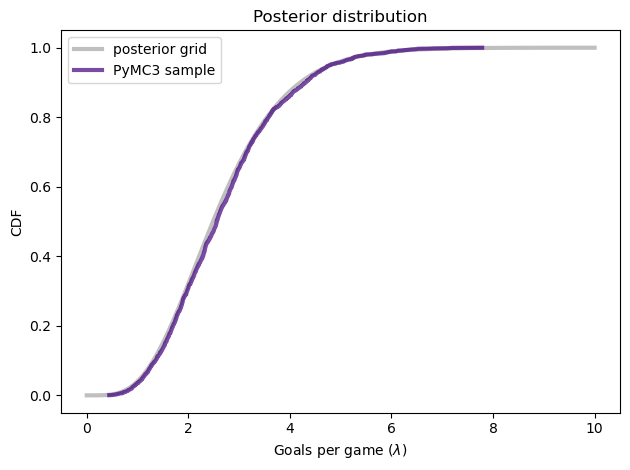

In [64]:
posterior.make_cdf().plot(label='posterior grid', color='C5')
plot_cdf(sample_post_pymc, label='PyMC3 sample', color='C4')

decorate(xlabel=r'Goals per game ($\lambda$)', ylabel='CDF', title='Posterior distribution')

<br>

## 19.07. 사후예측분포

<br>

### `MCMC객체.sample_posterior_predictive()` : 사후예측분포 표본 추출

In [65]:
with model2:
    post_pred = pm.sample_posterior_predictive(trace2)

In [67]:
sample_post_pred_pymc = post_pred['goals']
sample_post_pred_pymc.shape

(2000,)

<br>

#### 그리드 근사법의 사후예측분포와의 비교

In [68]:
sample_post = posterior.sample(1000)
sample_post_pred = poisson(sample_post).rvs()

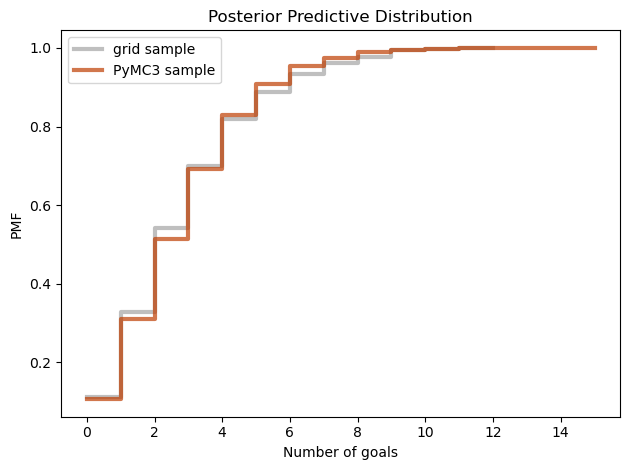

In [69]:
plot_pred(sample_post_pred, label='grid sample', color='C5')
plot_pred(sample_post_pred_pymc, label='PyMC3 sample', color='C12')

decorate(xlabel='Number of goals', ylabel='PMF', title='Posterior Predictive Distribution')

<br>

#### `PyMC3`은 복잡한 모델에서 높은 성능을 보여줌

<br>

## 19.08. 행복

> 에스테반 오르티즈-오스피나와 막스 로저의 ["행복과 삶의 만족도"](https://ourworldindata.org/happiness-and-life-satisfaction)라는 글에서, 수입과 행복 간의 관계를 국가별, 지역별, 연도별로 탐색.
> 
> 이 글은 6가지 가능한 예측 요인과의 관계를 탐색한 여러 [회귀분석](https://worldhappiness.report/ed/2020/social-environments-for-world-happiness/) 결과가 실린 ["세계 행복 보고서"](https://worldhappiness.report/)를 참조

<br>

* 1인당 GDP로 나타낸 수입
- 사회 복지
- 건강 기대수명
- 선ㄴ택의 자유
- 관용
- 부패에 대한 관점


<br>

종속변수는 [갤럽 월드 폴](https://news.gallup.com/poll/122453/understanding-gallup-uses-cantril-scale.aspx)에서 사용한 켄트럴 사다리 질문에 대한 응답의 국가별 평균

> 계단 맨 아래에 0이 있고 제일 끝에 10이 있는 사다리를 상상해보자. 사다리 꼭대기는 당신이 누릴 수 있는 최상의 삶을 나타내고 바닥은 가능한 최악의 삶을 나타낸다. 그렇다면 당신은 본인이 생각하기에 사다리의 몇 번 계단에 있는 것 같은가?



In [70]:
download('https://happiness-report.s3.amazonaws.com/2020/WHR20_DataForFigure2.1.xls')

Downloaded WHR20_DataForFigure2.1.xls


In [11]:
import pandas as pd

In [74]:
filename = 'WHR20_DataForFigure2.1.xls'
df = pd.read_excel(filename)

df.head(3)

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900826,0.949172,-0.059482,0.195445,1.972317,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.972317,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.972317,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267


<br>

- `Ladder score` : 행복 척도값. 예측변수

In [79]:
score = df['Ladder score']

<br>

## 19.09. 단순회귀

#### 1인당 GDP로 나타난 수입과 행복과의 관계

- `'Logged GDP per capita'` 열은 [PPP](https://en.wikipedia.org/wiki/Purchasing_power_parity) 기준 각 국가별 GDP를 인구 수로 나눈 후로 보정한 후 자연로그를 취한 값

In [80]:
log_gdp = df['Logged GDP per capita']

#### PPP기준 1인당 GDP로그 산점도

In [12]:
import matplotlib.pyplot as plt

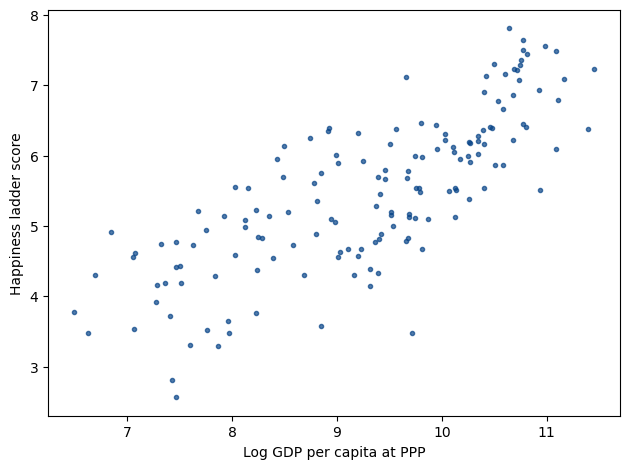

In [82]:
plt.plot(log_gdp, score, '.')

decorate(xlabel='Log GDP per capita at PPP', ylabel='Happiness ladder score')

<br>

#### `scipy.stats`의로 단순회귀 적용
- 추정 기울기는 약 0.72로, 1 로그 GDP당 0.72만큼 증가 

In [13]:
from scipy.stats import linregress

In [86]:
result = linregress(log_gdp, score)

In [87]:
pd.DataFrame([result.slope, result.intercept],
             index=['Slope', 'Intercept'],
             columns=[''])

,
Slope,0.717738
Intercept,-1.198646


<br>

### `PyMC3` 회귀분석

$$y = a x + b + \epsilon$$

- $y$는 종속변수 (사다리 점수)
- $x$는 예측변수 (로그 GDP)
- $\epsilon$은 $\sigma$를 표준편차로 가지는 정규분포를 따르는 잔차


In [88]:
x_data = log_gdp
y_data = score

<br>

#### 매개변수별 사전분포
- **$a$, $b$, $\sigma$에 대한 균등사전분포 생성**
  
<br>

#### 사전결합분포
- `y_est`는 회귀식 기반의 종속변수 추정값
    
<br>

#### 사후결합분포
- **`y`는 평균  `y_est`에 표준편차 `sigma`를 가지는 정규분포**

    **`observed=y_data`를 통하여 갱신 $\rightarrow$ 사후결합분포**

In [89]:
with pm.Model() as model3:
    a = pm.Uniform('a', 0, 4)
    b = pm.Uniform('b', -4, 4)
    sigma = pm.Uniform('sigma', 0, 2)

    y_est = a * x_data + b
    y = pm.Normal('y', mu=y_est, sd=sigma, observed=y_data)

<br>

#### 사후결합분포 표본추출


In [91]:
with model3:
    trace3 = pm.sample(500, **options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\FORYOUCOM\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 383 seconds.


<br>

#### 매개변수의 사후주변분포
- **KDE로 추정한 표본의 분포와 94% 신용구간**
- HDI (Highest Density Interval) : 최고밀도구간

In [93]:
trace3

<MultiTrace: 4 chains, 500 iterations, 6 variables>

In [14]:
import arviz as az

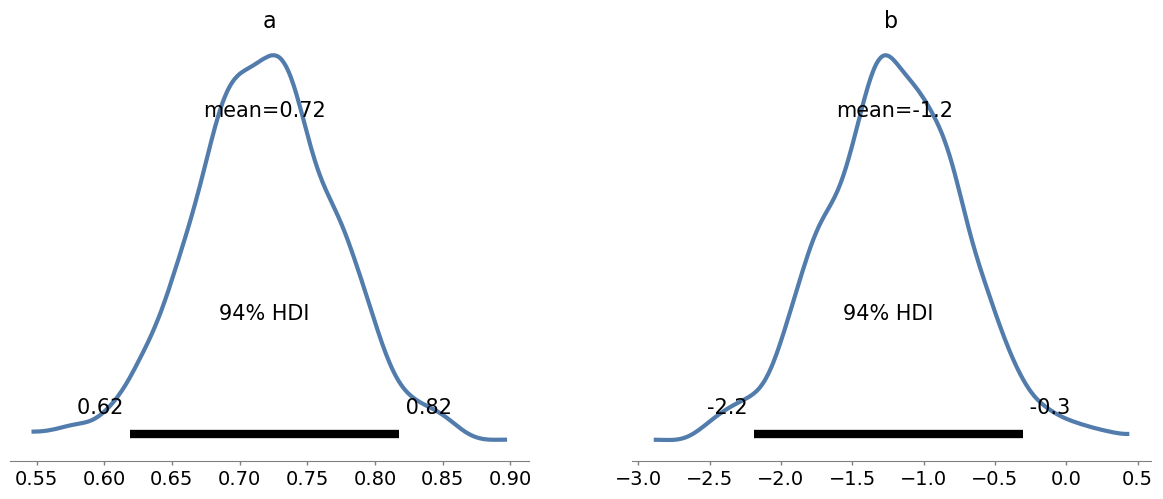

In [95]:
with model3:
    az.plot_posterior(trace3, var_names=['a', 'b']);

In [96]:
print('Sample mean:', trace3['a'].mean())
print('Regression slope:', result.slope)

Sample mean: 0.71819251370536
Regression slope: 0.7177384956304522


In [97]:
print('Sample mean:', trace3['b'].mean())
print('Regression intercept:', result.intercept)

Sample mean: -1.2049173922050043
Regression intercept: -1.198646061808887


<br>

- **$\sigma$의 사후주변분포**

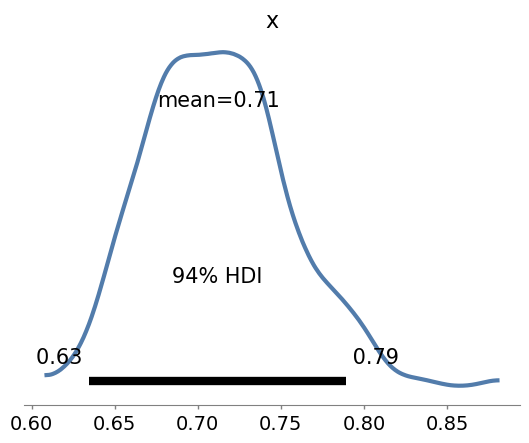

In [98]:
az.plot_posterior(trace3['sigma']);

#### 최소제곱회귀로 추정한 매개변수와 동일


<br>

## 19.10 다중회귀


In [103]:
columns = ['Ladder score', 'Logged GDP per capita', 'Social support', 'Healthy life expectancy',
           'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']

subset = df[columns]

In [104]:
subset.head(3)

,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,7.8087,10.639267,0.954330,71.900826,0.949172,-0.059482,0.195445
1,7.6456,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489
2,7.5599,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728


<br>

#### 모든 변수에 대해서 Standard-Scale

In [105]:
standardized = (subset - subset.mean()) / subset.std()

- 반응변수

In [107]:
y_data = standardized['Ladder score']

- 설명변수

In [108]:
x1 = standardized[columns[1]]
x2 = standardized[columns[2]]
x3 = standardized[columns[3]]
x4 = standardized[columns[4]]
x5 = standardized[columns[5]]
x6 = standardized[columns[6]]

<br>

#### `PyMC3` 객체 생성
- 각 회귀계수별 균등사전분포 생성
- 잔차 표준편차에 대한 균등 사전분포 생성
- `y_est` : 사전결합분포
- `y` : 사전결합분포를 `observed=y_data`로 갱신 $\rightarrow$ 사후결합분포

In [109]:
with pm.Model() as model4:
    b0 = pm.Uniform('b0', -4, 4)
    b1 = pm.Uniform('b1', -4, 4)
    b2 = pm.Uniform('b2', -4, 4)
    b3 = pm.Uniform('b3', -4, 4)
    b4 = pm.Uniform('b4', -4, 4)
    b5 = pm.Uniform('b5', -4, 4)
    b6 = pm.Uniform('b6', -4, 4)
    sigma = pm.Uniform('sigma', 0, 2)

    y_est = b0 + b1*x1 + b2*x2 + b3*x3 + b4*x4 + b5*x5 + b6*x6
    y = pm.Normal('y',  mu=y_est, sd=sigma, observed=y_data)

<br>

#### 사후예측분포 표본추출

In [110]:
with model4:
    trace4 = pm.sample(500, **options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\FORYOUCOM\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b6, b5, b4, b3, b2, b1, b0]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 860 seconds.


<br>

#### 사후결합분포 추정치
- **절편**

In [111]:
trace4['b0'].mean()

0.001021460548186425

- 잔차표준편차 $\sigma$

In [112]:
trace4['sigma'].mean()

0.5163980830573098

- 회귀계수별 추정치 및 94% 신용구간

In [113]:
param_names = ['b1', 'b3', 'b3', 'b4', 'b5', 'b6']

means = [trace4[name].mean() for name in param_names]

In [114]:
def credible_interval(sample):
    """94% 신용구간"""
    ci = np.percentile(sample, [3, 97])
    return np.round(ci, 3)

cis = [credible_interval(trace4[name]) for name in param_names]

<br>

In [115]:
index = columns[1:]
table = pd.DataFrame(index=index)
table['Posterior mean'] = np.round(means, 3)
table['94% CI'] = cis
table

,Posterior mean,94% CI
Logged GDP per capita,0.248,"[0.08, 0.415]"
Social support,0.224,"[0.07, 0.39]"
Healthy life expectancy,0.224,"[0.07, 0.39]"
Freedom to make life choices,0.188,"[0.088, 0.288]"
Generosity,0.057,"[-0.031, 0.145]"
Perceptions of corruption,-0.100,"[-0.197, -0.005]"


#### 행복은 GDP와 가장 강한 연관성이 있는 것 같고, 그 다음으로 사회 복지, 기대수명, 자유 순
#### 나머지 요인은 상대적으로 이에 비해 연관성이 약해보이고, 심지어 '관용'요인의 신용구간은 0을 포함하므로, '관용'은 이 행복과 상관이 없다고 볼 수 있음
#### 회귀분석의 목적이 매개변수 측정이라면, 베이지안 회귀가 전통적인 최소제곱회귀에 비해서 딱히 큰 장점은 없음
#### 베이지안 방법론은 의사결정 과정에서 매개변수의 사후분포를 사용할 때 더 유용

## 19.11 Summary

#### MCMC는 그리드 방법론에 비하여 더 강력하지만, 아래와 같은 단점이 존재
* MCMC는 절차적으로 복잡.
    - 동일한 모델도 어떤 사전분포에서는 더 잘 작동하고 어떤 분포에서는 성능이 떨어짐
    - 표본 추출 과정 단계중 튜닝, 발산 'r-hat 통계량', 채택률, 효과적 표본 등의 경고가 존재
    - 이를 조사하고 원인을 수정하려면 다소 전문적인 지식이 필요

    <br>
    
* 중간에 결과를 확인해 가며 점진적으로 모델을 해선하는 과정이 그리드 방법론이 더 쉬움
- `PyMC3`은 모델을 올바르게 정의했는지 확인하기가, 그리드 방법론보다 쉽지 않음

#### 그리드 방법론으로 모델을 개발한 후, 필요시 MCMC를 사용하는 것이 바람직

<br>

## 19.12. 에제

<br>

### (1)

> 동전을 250회 돌렸을 때, 앞 면이 140회
>
> 앞면이 나올 확률 $x$의 사후분포
> 
> 사전분포는 $\alpha=1,\; \beta=1$인 베타분포를 사용


연속형 분포의 목록: [the PyMC3 documentation](https://docs.pymc.io/api/distributions/continuous.html)참고

In [116]:
n = 250
k_obs = 140

In [117]:
with pm.Model() as model5:
    x = pm.Beta('x', alpha=1, beta=1)
    k = pm.Binomial('k', n=n, p=x, observed=k_obs)

In [118]:
with model5:
    trace5 = pm.sample(500, **options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 16 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\FORYOUCOM\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'x'}>

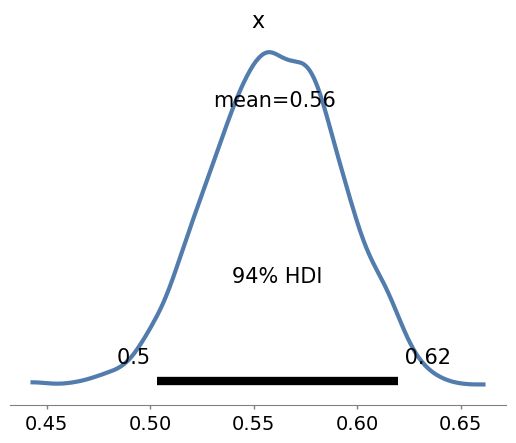

In [119]:
az.plot_posterior(trace5)

<br>

### (2)

> 첫 번째 실험애서 $k=23$마리의 곰을 확인
>
> 두 번째 실험에서 $n=19$마리의 곰을 식별하고 $x=4$마리의 곰이 확인
>
> 이곳에 있는 곰 $N$의 사후분포 추정
>
> 사전분포는 50~500의 이산균등분포를 사용



In [1]:
k = 23
n = 19
x = 4

In [15]:
with pm.Model() as model6:
    N = pm.DiscreteUniform('N', 50, 500)
    y = pm.HyperGeometric('y', N=N, k=k, n=n, observed=x)

In [18]:
with model6:
    trace6 = pm.sample(1000, **options)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [N]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\FORYOUCOM\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'N'}>

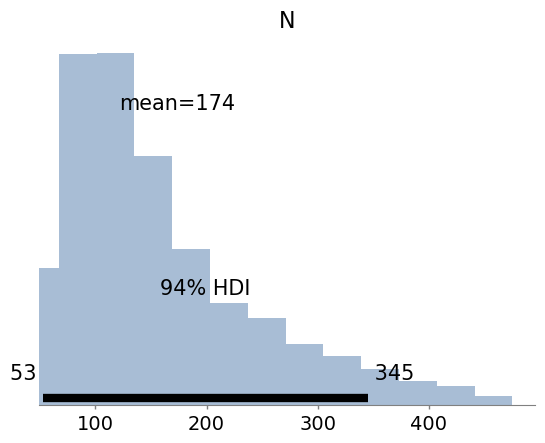

In [19]:
az.plot_posterior(trace6)

<br>

### (3)

> $\lambda=3,\;k=0.8$을 사용하는 와이블분포의 표본생성
>
> 해당 매개변수를 사용하는 사후분포의 그리드 근사 계산

In [20]:
data = [0.80497283, 2.11577082, 0.43308797, 0.10862644, 5.17334866, 3.25745053, 3.05555883, 2.47401062, 0.05340806, 1.08386395]

In [21]:
with pm.Model() as model7:
    lam = pm.Uniform('lam', 0.1, 10.1)
    k = pm.Uniform('k', 0.1, 5.1)
    y = pm.Weibull('y', alpha=k, beta=lam, observed=data)

In [22]:
with model7:
    trace7 = pm.sample(1000, **options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, lam]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Got error No model on context stack. trying to find log_likelihood in translation.


array([<AxesSubplot:title={'center':'lam'}>,
       <AxesSubplot:title={'center':'k'}>], dtype=object)

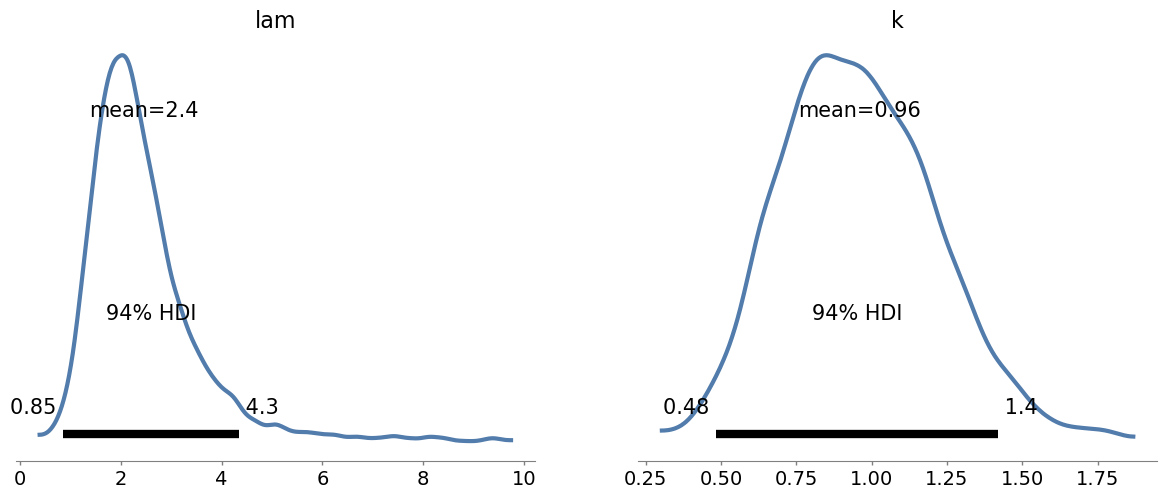

In [24]:
az.plot_posterior(trace7)

<br>

### (4)
> $\mu$와 $\sigma$에 대해 사전균등분포를 정의한 후 데이터를 사용해서 각각의 사후분포를 추정하는 모델 생성

In [ ]:
import pandas as pd

In [25]:
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/data/drp_scores.csv')

In [26]:
df = pd.read_csv('drp_scores.csv', skiprows=21, delimiter='\t')
df.head()

,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58
3,Treated,71
4,Treated,43


In [28]:
grouped = df.groupby('Treatment')
responses = {}

for name, group in grouped:
    responses[name] = group['Response']

In [29]:
data = responses['Treated']

In [31]:
with pm.Model() as model8:
    mu = pm.Uniform('mu', 20, 80)
    sigma = pm.Uniform('sigma', 5, 30)
    y = pm.Normal('y', mu, sigma, observed=data)
    trace8 = pm.sample(500, **options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\FORYOUCOM\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 23 seconds.


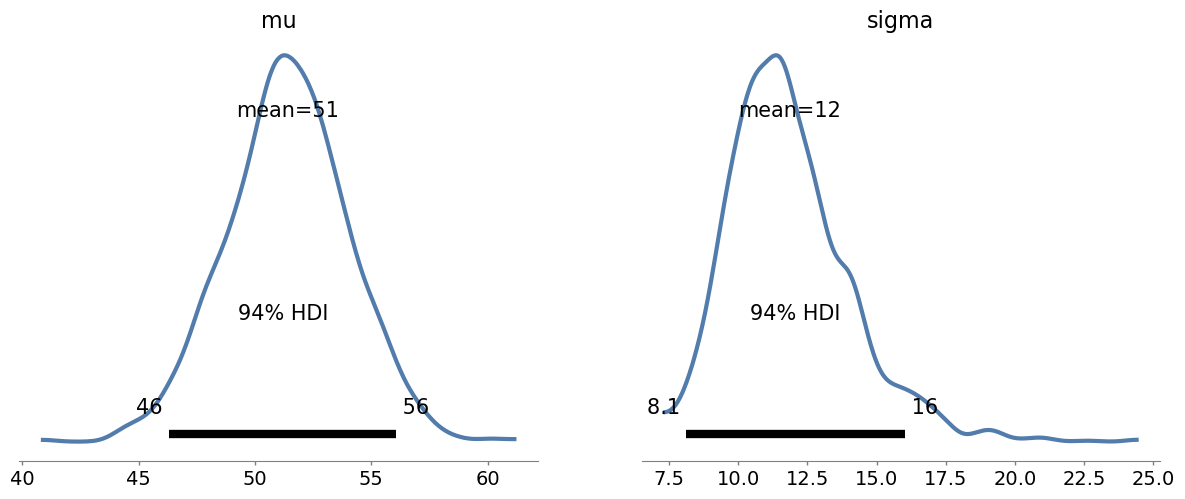

In [32]:
with model8:
    az.plot_posterior(trace8)

<br>

### (5)

> 한 검수자가 프로그램에서 20개의 버그를 발견했다고 하자. 이 때 실제로 프로그램에는 몇 개의 버그가 있는지 추정해야 한다. 프로그램에 최소한 20개의 버그가 있다는 것은 알고 있고, 검수자에 대한 돈독한 신뢰가 있다면, 대략 버그의 수는 20개 내외일 것이라고 볼 것이다. 한 검수자의 능력이 그다지 좋지 않다면 수백개의 버그가 있을 지도 모를 일이다. 이 때 버그가 어느 정도인지를 파악할 만한 방법은 한 명의 검수자로는 알 수 없다. 하지만 검수자가 두 명이라면 해당 검수자들의 능력치를 알지 않고도 이를 추정할 방안이 있다

<br>

#### 첫 번째 검수자가 20개의 버그를 찾고, 두 번째 검수자가 15개의 버그를 찾았으며, 두 검수자가 동시에 찾은 버그는 3개이다. 이 경우 총 버그의 수는 몇 개일지를 계산



* `k11` : 두 검수자가 모두 발견한 버그의 개수,

* `k10` : 첫 번째 검수자에 의해 발견되었지만, 두 번째 검수자에게는 발견되지 않은 버그의 수

* `k01` : 첫 번째 검수자에 의해 발견되지 않았지만, 첫 번째 검수자에게는 발견된 버그의 수

* `k00` : 두 검수자가 모두 발견하지 못한 버그의 개수


In [39]:
k10 = 20 - 3
k01 = 15 - 3
k11 = 3

In [40]:
num_seen = k01 + k10 + k11
num_seen

32

<br>

#### 데이터가 $N$에 따라 다른 `k00`을 포함하고 있음

```
k00 = N - num_seen
```


<br>

#### 따라서, 데이터를 모델의 일부로 만들어야 함. 이때 다음과 같이 배열을 만드는 `pm.math.stack()`

#### `pm.math.stack()`


```
data = pm.math.stack((k00, k01, k10, k11))
```

In [35]:
with pm.Model() as model9:
    p0 = pm.Beta('p0', alpha=1, beta=1)
    p1 = pm.Beta('p1', alpha=1, beta=1)
    N = pm.DiscreteUniform('N', num_seen, 350)
    
    q0 = 1-p0
    q1 = 1-p1
    ps = [q0*q1, q0*p1, p0*q1, p0*p1]
    
    k00 = N - num_seen
    data = pm.math.stack((k00, k01, k10, k11))
    y = pm.Multinomial('y', n=N, p=ps, observed=data)

In [36]:
with model9:
    trace9 = pm.sample(1000, **options)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p1, p0]
>Metropolis: [N]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.7128578171146462, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8924014425073212, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


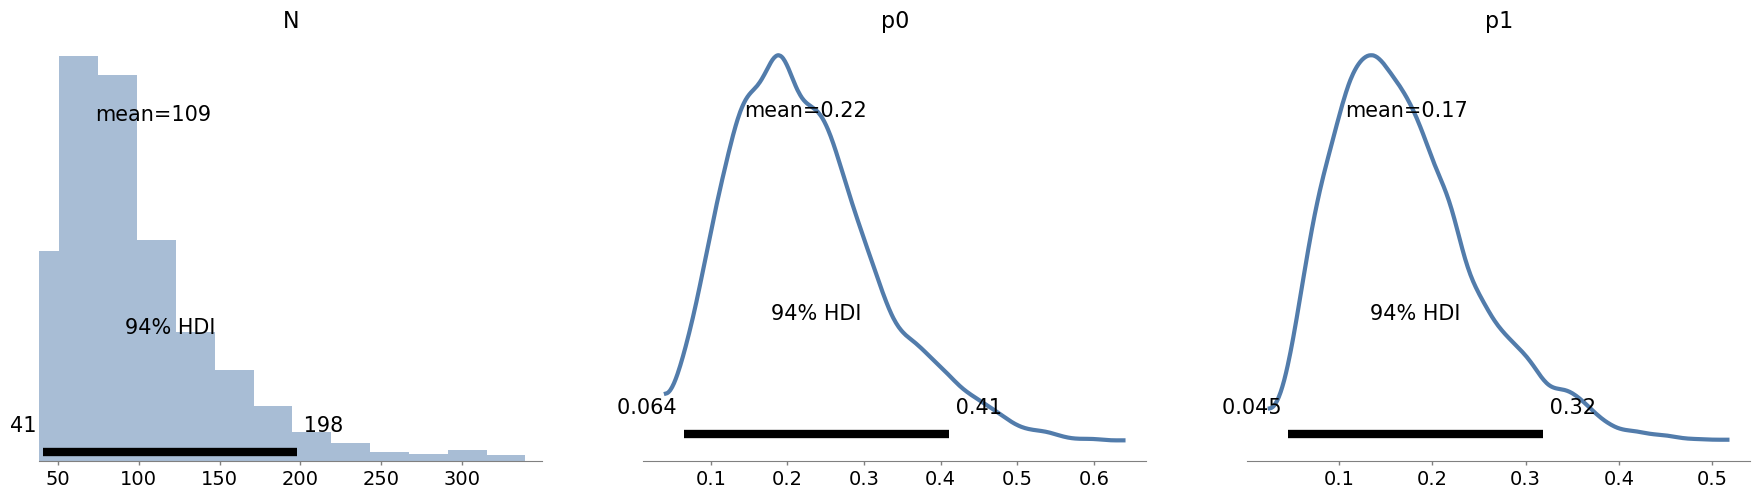

In [37]:
with model9:
    az.plot_posterior(trace9)